In [1]:
#basic package
import json
import tqdm
import os
import numpy as np
import glob
import pandas as pd
import sys
import shutil
import time
import datetime as dt
import itertools
import time
import re
from collections import Counter
from collections import defaultdict
import operator
import math
import functools
import collections
from sklearn.metrics import confusion_matrix
import random
from sklearn.utils import shuffle

#plot
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
PACKAGE_PARENT = '../'
SCRIPT_DIR = os.path.dirname(os.path.realpath(os.path.join(os.getcwd(), os.path.expanduser('__file__'))))
sys.path.append(os.path.normpath(os.path.join(SCRIPT_DIR, PACKAGE_PARENT)))
from UTILS import is_WG_open, cleaning_processing, preprocessing_Origins
import config_origins as config

ModuleNotFoundError: No module named 'UTILS'

In [ ]:
print('change the configuration file if not done yet!')
path_extracted_data = config.path_extracted_data
path_initial_data = config.path_initial_data
id_run = config.id_run
dico_matching = config.dico_matching
date_first_opening_WG = config.date_first_opening_WG
dico_garden_opening_hour = config.dico_garden_opening_hour
print(id_run)
path_cleaning_records = r'G:\VPHI\Welfare\2- Research Projects\OFHE2.OriginsE2\GantnerSystem\GantnerCleaning\Results'
path_extracted_data_cleaning = os.path.join(path_extracted_data,'Cleaning')
#path_extracted_data_cleaning = r'D:\vm_exchange\PhD_Data\LogsCleaning'
#create a director if not existing
if not os.path.exists(path_extracted_data_cleaning):
    os.makedirs(path_extracted_data_cleaning)

# Download Students records

df_WG = pd.read_excel(os.path.join(path_cleaning_records,'Pen8_WG_CM.xlsm'), parse_dates=['Timestamp'], index_col=False)
df_WG['type'] = 'studentsWGspecific'
df_WG['algo_type'] = 'cleaning'
print(df_WG.shape)
df_WG.head(3)

In [ ]:
df_records = pd.read_csv(os.path.join(path_cleaning_records,'Results_all.csv'), parse_dates=['Date'], sep=';')
df_records = df_records.dropna(subset=['VideoAnalyse'])
df_records['Timestamp'] = df_records.apply(lambda x: dt.datetime(x['Date'].year, x['Date'].month, x['Date'].day, 
                                                             int(x['Time'].split(':')[0]), int(x['Time'].split(':')[1]), 
                                                             int(x['Time'].split(':')[2])), axis=1)
df_records.drop_duplicates(subset=['Timestamp','TagID'], keep='last', inplace=True)
df_records['type'] = 'students'
print(df_records.shape)
df_records.head(3)

In [ ]:
df_records['Zone'].unique()

In [ ]:
#first check the accuracy per verification batch
df_ver = df_records[df_records['algo_type']=='verification'].copy()
df_ver = df_ver.groupby(['BatchID'])[['VideoAnalyse','Zone']].agg(lambda x: list(x)).reset_index()
df_ver['VideoAnalyse'] = df_ver['VideoAnalyse'].map(lambda x: [i for i in x if i in ['0','1']])
df_ver['accuracy'] = df_ver['VideoAnalyse'].map(lambda x: sum([i=='1' for i in x])/len(x))
df_ver['nbr_transition'] = df_ver['VideoAnalyse'].map(lambda x: len(x))
display(df_ver[df_ver['accuracy']==min(df_ver['accuracy'].tolist())])
df_ver.head(5)

In [ ]:
#remove WG from cleaning (keeping for verification) as unsure of any time when its actually true, due to the cameras not 
#filming the pophole
print(df_records.shape)
df_records = df_records[~((df_records['Zone']=='Wintergarten')&(df_records['algo_type']=='cleaning'))]
print(df_records.shape)

In [ ]:
df_records[df_records['VideoAnalyse'].isin(['0','1'])].shape

#### concat all

In [ ]:
#df_students = pd.concat([df_WG, df_records])
df_students = df_records.dropna(subset=['VideoAnalyse'])
df_students['VideoAnalyse'] = df_students['VideoAnalyse'].map(lambda x: str(x).strip())
df_students['Zone'] = df_students['Zone'].map(lambda x: config.dico_matching[x])
df_students['TagID'] = df_students['TagID'].astype(int).astype(str)
df_students['TagID'] = df_students['TagID'].map(lambda x: 'tag_'+str(x))
df_students.drop_duplicates(subset=['Timestamp','TagID'], keep='last', inplace=True)
df_students.rename(columns={'Date':'date'}, inplace=True)
df_students['next_was_missed'].fillna(0,inplace=True)
df_students['is_first_observation'].fillna(0,inplace=True)
print(df_students.shape)
df_students.head(3)

# Add henID, previous and next zones from raw data

In [ ]:
p = glob.glob(os.path.join(path_initial_data, 'Barn 4 Pen*\TagUpdates\log*'))
#print('There is %d log files:\n  %s'%(len(p),'  \n  '.join(p)))
df = preprocessing_Origins(p, config, save=True, dodevice=False)
print(df.shape)
display(df.head(2))
display(df.tail(2))

In [ ]:
#download data and add the necessary processing as the duration, next/previous zones etc
df = cleaning_processing(date_min=dt.datetime(2020,10,1), date_max=dt.datetime(2020,10,30), config=config)
print(df.shape)
df.head(3)

In [ ]:
#merge info on the students file
df_students_info = pd.merge(df_students.filter(['Timestamp', 'TagID', 'Zone', 'VideoAnalyse','is_first_observation',
                                                'Date', 'BirdID', 'type','algo_type','BatchID','next_was_missed'], axis=1), 
                            df, on=['Timestamp','TagID','Zone'], how='left')

#add observed zone, note that when its equal to 1 or 3, it means that the zone was correctly observed
df_students_info['Observed_Zone'] = df_students_info.apply(lambda x: x['Zone'] if str(x['VideoAnalyse']) in ['1','3'] else \
                                                          x['previous1_zone'], axis=1)
#what makes it complicate: if after a missed zone the record was incorrectly registered, then we would need to say that the
#observed zone is not the previous_registered zone ("previous1_zone"), but the missed zone. Hence, we will only use the first
#record of each verification batch as well as all the records linked to a VideoAnalyse=1 or 3 in the 
#"4_CleaningMethodsComparison.ipynb"
print(df_students_info.shape)
df_students_info.head(3)

#### check nan values

In [47]:
#df_students_info[(df_students_info['Observed_Zone'].isnull())&(df_students_info['VideoAnalyse'].isin(['0','1']))]['TagID'].value_counts()
df_students_info[(df_students_info['Observed_Zone'].isnull())&(df_students_info['VideoAnalyse'].isin(['0','1']))]

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Timestamp,TagID,Zone,VideoAnalyse,is_first_observation,BirdID,type,algo_type,BatchID,next_was_missed,...,next5_zone,previous5_zone,previousZone==NextZone,zone2_match,zone3_match,zone4_match,zone3_match_exist,next2zone==Zone,previous2zone==Zone,Observed_Zone


In [48]:
#remove added zone by students
print(df_students_info.shape)
df_students_info  = df_students_info[(~df_students_info['Zone'].isnull())|(df_students_info['VideoAnalyse']=='3')]
print(df_students_info.shape)

(5315, 47)
(5222, 47)


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [49]:
print(df_students_info.shape)
print(df_students_info[df_students_info['VideoAnalyse'].isnull()].shape)
df_students_info[df_students_info['duration'].isnull()]
#-->we will remove those

(5222, 47)
(0, 47)


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Timestamp,TagID,Zone,VideoAnalyse,is_first_observation,BirdID,type,algo_type,BatchID,next_was_missed,...,next5_zone,previous5_zone,previousZone==NextZone,zone2_match,zone3_match,zone4_match,zone3_match_exist,next2zone==Zone,previous2zone==Zone,Observed_Zone
1196,2020-10-17 13:22:00,tag_117,2_Zone,1,0.0,10sp,students,cleaning,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2_Zone
3061,2020-10-15 13:05:45,tag_75,2_Zone,1,0.0,8sb,students,verification,ID6,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2_Zone
3428,2020-10-21 12:50:26,tag_125,5_Zone,3,0.0,10pp,students,verification,ID27,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5_Zone
3429,2020-10-21 12:50:29,tag_125,4_Zone,3,0.0,10pp,students,verification,ID27,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4_Zone
3456,2020-10-21 13:43:25,tag_125,2_Zone,3,0.0,10pp,students,verification,ID27,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2_Zone
3457,2020-10-21 13:43:31,tag_125,3_Zone,3,0.0,10pp,students,verification,ID27,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3_Zone
3531,2020-10-23 15:50:35,tag_62,4_Zone,3,0.0,5bb,students,verification,ID30,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4_Zone
4358,2020-10-16 14:43:53,tag_158,2_Zone,Tier 1,0.0,11bb,students,cleaning,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4365,2020-10-16 15:14:17,tag_158,2_Zone,Tier 1,0.0,11bb,students,cleaning,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4369,2020-10-16 13:59:34,tag_140,3_Zone,1,0.0,11wp,students,cleaning,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3_Zone


In [50]:
df_students_info  = df_students_info[(~df_students_info['duration'].isnull())|(df_students_info['VideoAnalyse']=='3')]
print(df_students_info.shape)

(5217, 47)


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [51]:
#df_students_info[df_students_info['VideoAnalyse']=='Tier 2'] #students error. but wil be removed
df_students_info['VideoAnalyse'].value_counts()

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


1     4559
0      578
-1      75
3        5
Name: VideoAnalyse, dtype: int64

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,next transition was missed,number of wrong records,minimum duration
0,0.0,109,100
1,1.0,1,100
0,0.0,107,101


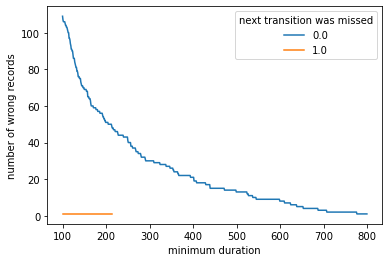

In [52]:
df_ = df_students_info[(df_students_info['algo_type']=='cleaning')&\
                          (df_students_info['type']=='students')&\
                          (df_students_info['VideoAnalyse']=='0')]
li_df = []
for v in range(100,800):
    df__ = df_[df_['duration']>v]['next_was_missed'].value_counts().reset_index()
    df__.rename(columns={'index':'next transition was missed', 'next_was_missed':'number of wrong records'}, inplace=True)
    df__['minimum duration'] = v
    li_df.append(df__)
df_plt = pd.concat(li_df)
display(df_plt.head(3))
sns.lineplot(data=df_plt, hue='next transition was missed', x='minimum duration',y='number of wrong records');
plt.savefig(os.path.join(path_extracted_data_cleaning, 'MissedTransition_duration.png'), bbox_inches='tight')
#--> bigger than 10 minutes, do not filter the record!!
#small verification
#df__ = df_[(df_['duration']>700)&(df_['VideoAnalyse']=='0')]['next_was_missed'].value_counts().reset_index()
#df__.rename(columns={'index':'next transition was missed', 'next_was_missed':'nbr records'})

#TO KEEP
li_df = []
df_ = df_students_info[(df_students_info['algo_type']=='cleaning')&\
                          (df_students_info['type']=='students')&\
                          (df_students_info['VideoAnalyse']!='-1')]
for v in range(1,121):
    df__ = df_[(df_['duration']<v)&(df_['next_was_missed']==0)]['VideoAnalyse'].value_counts().reset_index()
    df__.rename(columns={'index':'VideoAnalysis', 'VideoAnalyse':'number of records'}, inplace=True)
    df__['maximum duration'] = v
    li_df.append(df__)
df_plt = pd.concat(li_df)
display(df_plt.head(3))
sns.lineplot(data=df_plt, hue='VideoAnalysis', x='maximum duration',y='number of records');
#--> under 60 seconds, there is still much more correct records than not correct ones! but thats perhaps not transitions!!
#hence not saved as no need for now, and better to change with real transition as binning doe snot intend to remove wrong
#records, but intend to remove all records that is not a transition!!!!


#AGAIN ONLY MAKE SENCE IF WE SPEAK ABOUT TRANSITIONAL RECORDS ONLY
#duration of wrong records before removing nan and hence the missed records
df_ = df_students_info[(df_students_info['algo_type']=='cleaning')&\
                          (df_students_info['type']=='students')&\
                          (df_students_info['VideoAnalyse']!='-1')&\
                          ~((df_students_info['duration']>2000)&(df_students_info['VideoAnalyse']=='1'))]
sns.boxplot(data=df_, y='duration', x='VideoAnalyse', hue='next_was_missed');
plt.savefig(os.path.join(path_extracted_data_cleaning, 'MissedTransition_duration.png'), bbox_inches='tight')
#--> bigger than 8 minutes, do not filter the record!!

In [17]:
#print rows with nan values
#df[df.isnull().any(axis=1)]

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Select more based on best MLPs

df_new_observation = df[df['date'].isin([dt.datetime(2020,10,21), dt.datetime(2020,10,23), dt.datetime(2020,10,24), 
                                        dt.datetime(2020,10,25), dt.datetime(2020,10,26)])].copy()
df_new_observation['hours'] = df_new_observation['Timestamp'].map(lambda x: x.hour)
df_new_observation = df_new_observation[df_new_observation['hours'].isin([10,11,12,13,14,15,16,17])]
print(df_new_observation.shape)
df_new_observation.head(3)

df_ = df_new_observation[df_new_observation['hours'].isin([13,14,15,16,17])]
print(df_.shape)
df_ = df_.groupby(['HenID','date']).agg(
    nbr_transition=pd.NamedAgg(column='Zone', aggfunc=lambda x: len(list(x))),
    nbr_WG= pd.NamedAgg(column='Zone', aggfunc=lambda x: sum([i=='1_Zone' for i in x]))).reset_index()
df_[df_['nbr_WG']>8]

df_ = df_new_observation.groupby(['HenID','date']).agg(
    nbr_transition=pd.NamedAgg(column='Zone', aggfunc=lambda x: len(list(x))),
    nbr = pd.NamedAgg(column='Zone', aggfunc=lambda x: sum([i=='2_Zone' for i in x]))).reset_index()
df_[df_['nbr']>30].head(20)

df_ = df_new_observation.groupby(['HenID','date']).agg(
    nbr_transition=pd.NamedAgg(column='Zone', aggfunc=lambda x: len(list(x))),
    nbr = pd.NamedAgg(column='Zone', aggfunc=lambda x: sum([i=='4_Zone' for i in x]))).reset_index()
df_[df_['nbr']>20]

# Add WG records when closed to cleaning procedure

df['hour'] = df['Timestamp'].map(lambda x: x.hour)
df['is_WG_open'] = df['hour'].map(lambda x: (x<9)|(x>18))
print(df['is_WG_open'].value_counts())

#add other restriction to make sure we dont influence badly the algorithm (add most strongest case)
df_WGlogs = df[(~df['is_WG_open'])&(df['Zone']=='1_Zone')&(df['duration']<180)&(df['signalstrength']<8)&\
               (df['date']<dt.datetime(2020,10,31))&(df['date']>dt.datetime(2020,10,1))].copy()
#df_WGlogs['BirdID'] = df_WGlogs.apply(lambda x: str(x['PenID'])+x['backpackID'],axis=1)
df_WGlogs['VideoAnalyse'] = 0
df_WGlogs['type'] = 'logs'
df_WGlogs['algo_type'] = 'cleaning'
#if we want more info: merge this on tagID et date with the logs having the next_zone and duration and a list of 
#previous and next zone
print(df_WGlogs.shape)
df_WGlogs.head(3)

#keep only part of it for the cleaning process (not the verification, as we want this to be representatif of the overall data)
#keep 100 values 
df_WGlogs = shuffle(df_WGlogs)
df_WGlogs = df_WGlogs[0:100]
df_WGlogs.head(3)

li_col = ['Timestamp','TagID', 'HenID', 'Zone', 'PenID','VideoAnalyse', 'system', 'date','type', 'signalstrength', 
          'signalstzone2', 'signalstrzone3', 'signalstrzone4','zone2_match','zone3_match','zone4_match',
          'next1_zone','next2_zone', 'next3_zone', 'next4_zone', 'next5_zone',
          'previous1_zone', 'previous2_zone', 'previous3_zone', 'previous4_zone','previous5_zone',
          'duration','previous_duration','algo_type','BatchID','previousZone==NextZone','next_duration',
          'next2zone==Zone','previous2zone==Zone','zone3_match_exist','is_first_observation']
print(df_WGlogs.shape, df_students_info.shape)
df_algo = pd.concat([df_WGlogs.filter(li_col, axis=1), df_students_info.filter(li_col, axis=1)])
df_algo['VideoAnalyse'] = df_algo['VideoAnalyse'].map(lambda x: str(x).strip())
print(df_algo.shape)
df_algo.head(3)

# Saving of final Input data for algo

In [18]:
li_col = ['Timestamp','TagID', 'HenID', 'Zone', 'PenID','VideoAnalyse', 'system', 'date','type', 'signalstrength', 
          'signalstzone2', 'signalstrzone3', 'signalstrzone4','zone2_match','zone3_match','zone4_match',
          'next1_zone','next2_zone', 'next3_zone', 'next4_zone', 'next5_zone',
          'previous1_zone', 'previous2_zone', 'previous3_zone', 'previous4_zone','previous5_zone',
          'duration','previous_duration','algo_type','BatchID','previousZone==NextZone','next_duration',
          'next2zone==Zone','previous2zone==Zone','zone3_match_exist','is_first_observation']
df_students_info = df_students_info.filter(li_col, axis=1)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [19]:
df_students_info.groupby(['type','algo_type'])['VideoAnalyse'].count().reset_index()

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,type,algo_type,VideoAnalyse
0,students,cleaning,4331
1,students,verification,886


In [20]:
df_students_info['algo_type'].value_counts()

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


cleaning        4331
verification     886
Name: algo_type, dtype: int64

In [21]:
#add human observed zone
df_students_info['Observed_Zone'] = df_students_info.apply(lambda x: x['Zone'] if str(x['VideoAnalyse']) in ['1','3'] else x['previous1_zone'], axis=1)
#VideoAnalyse=3: stands for the missed zone in the verification dataset
df_students_info = df_students_info[df_students_info['VideoAnalyse'].isin(['0','1','3'])]
df_students_info['VideoAnalyse'] = df_students_info['VideoAnalyse'].map(lambda x: int(x))
df_students_info = shuffle(df_students_info)
df_students_info.rename(columns={'Zone':'Trackingsystem_Zone'}, inplace=True)
df_students_info.to_csv(os.path.join(path_extracted_data_cleaning, id_run+'InputCleaning.csv'), sep=';', index=False)      

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Look at the data repartition across zone and correct/false that we will use

In [22]:
df_testing = df_students_info[df_students_info['algo_type']=='verification'].copy()
df_testing.groupby(['Trackingsystem_Zone','VideoAnalyse','type'])['date'].count().reset_index()

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Trackingsystem_Zone,VideoAnalyse,type,date
0,1_Zone,0,students,3
1,1_Zone,1,students,24
2,2_Zone,0,students,2
3,2_Zone,1,students,146
4,2_Zone,3,students,0
5,3_Zone,0,students,29
6,3_Zone,1,students,509
7,3_Zone,3,students,0
8,4_Zone,0,students,7
9,4_Zone,1,students,86


In [23]:
df_cleaning = df_students_info[df_students_info['algo_type']=='cleaning'].copy()
df_cleaning.groupby(['Trackingsystem_Zone','VideoAnalyse','type'])['date'].count().reset_index()

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Trackingsystem_Zone,VideoAnalyse,type,date
0,2_Zone,0,students,15
1,2_Zone,1,students,901
2,3_Zone,0,students,468
3,3_Zone,1,students,1925
4,4_Zone,0,students,18
5,4_Zone,1,students,386
6,5_Zone,0,students,35
7,5_Zone,1,students,526


In [24]:
df_students_info['VideoAnalyse'].value_counts()

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


1    4559
0     578
3       5
Name: VideoAnalyse, dtype: int64

In [25]:
df_students_info['algo_type'].value_counts()

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


cleaning        4274
verification     868
Name: algo_type, dtype: int64

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\camil\anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass labels=['2_Zone', '3_Zone', '4_Zone', '5_Zone'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
<ipython-input-26-faac09e578fa>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
<ipython-input-26-faac09e578fa>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


[[147  14   0   0]
 [  2 510   2   1]
 [  0   1  88   0]
 [  0  14   5  57]]


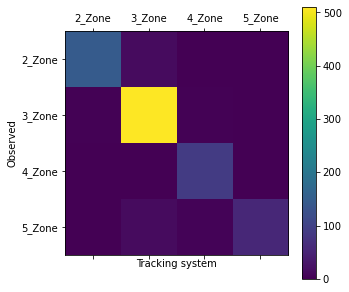

In [26]:
#we will only look at when the records was wrongly recorded, not when we issed a record, due to results from validation: only
#very very few such cases
labels = ['2_Zone', '3_Zone', '4_Zone', '5_Zone']
#y_true, y_pred
cm = confusion_matrix(df_testing['Observed_Zone'].tolist(), df_testing['Trackingsystem_Zone'].tolist(), labels)
print(cm)
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
#plt.title('Confusion matrix of the Tracking system')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Tracking system')
plt.ylabel('Observed')
plt.savefig(os.path.join(path_extracted_data_cleaning, id_run+'_confusion_matrix_testing_rawdata.png'), bbox_inches='tight')
plt.show()

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-27-8fa20f5553dc>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
<ipython-input-27-8fa20f5553dc>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


[[ 902   71    0   12]
 [  13 1929    8   20]
 [   0    9  386    3]
 [   1  384   10  526]]


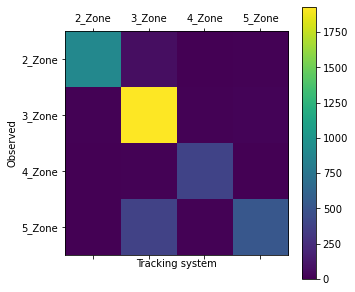

In [27]:
#we will only look at when the records was wrongly recorded, not when we issed a record, due to results from validation: only
#very very few such cases
labels = ['2_Zone', '3_Zone', '4_Zone', '5_Zone']
#y_true, y_pred
cm = confusion_matrix(df_cleaning['Observed_Zone'].tolist(), df_cleaning['Trackingsystem_Zone'].tolist(), labels)
print(cm)
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
#plt.title('Confusion matrix of the Tracking system')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Tracking system')
plt.ylabel('Observed')
plt.savefig(os.path.join(path_extracted_data_cleaning, id_run+'_confusion_matrix_cleaning_rawdata.png'), bbox_inches='tight')
plt.show()

In [28]:
#stats for paper
df_students_info = pd.read_csv(os.path.join(path_extracted_data_cleaning, id_run+'InputCleaning.csv'), parse_dates=['Timestamp', 'date'], 
                 dayfirst=True, sep=';')
df_students_info['VideoAnalyse'] = df_students_info['VideoAnalyse'].map(lambda x: int(x)) #not before as tehre was srting as well
df_students_info = df_students_info[df_students_info['VideoAnalyse'].isin([0,1])]
df_students_info = shuffle(df_students_info)
print(df_students_info.shape)
df_students_info.head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(5137, 35)


,Timestamp,TagID,HenID,Trackingsystem_Zone,PenID,VideoAnalyse,system,date,type,signalstrength,...,previous_duration,algo_type,BatchID,previousZone==NextZone,next_duration,next2zone==Zone,previous2zone==Zone,zone3_match_exist,is_first_observation,Observed_Zone
4482,2020-10-15 12:48:51,tag_60,hen_88,3_Zone,pen5,0,3 - 5,2020-10-15,students,10.0,...,9.0,cleaning,NaN,False,1231.0,1.0,1.0,1.0,0.0,5_Zone
572,2020-10-17 15:45:59,tag_90,hen_158,3_Zone,pen8,1,8 - 9,2020-10-17,students,15.0,...,61.0,cleaning,NaN,False,39.0,1.0,0.0,1.0,0.0,3_Zone
792,2020-10-24 16:41:28,tag_135,hen_46,1_Zone,pen10,1,10 - 12,2020-10-24,students,7.0,...,726.0,verification,ID40,True,492.0,0.0,0.0,0.0,0.0,1_Zone


In [38]:
df_d = df_students_info[df_students_info['algo_type']=='cleaning']['date'].value_counts().reset_index()
print('There is %d dates with more than 10 observations'%df_d[df_d['date']>10].shape[0])

There is 11 dates with more than 10 observations


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [30]:
#number of observations per tracking system
df_students_info[df_students_info['algo_type']=='cleaning'].groupby(['system'])['HenID'].count().reset_index()

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,system,HenID
0,10 - 12,1407
1,3 - 5,1740
2,8 - 9,1127


In [39]:
#number of involved hens per tracking system for the cleaning dataset
df_students_info[df_students_info['algo_type']=='cleaning'].groupby(['system'])['HenID'].agg(lambda x: len(set(x))).reset_index()

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,system,HenID
0,10 - 12,15
1,3 - 5,18
2,8 - 9,13


In [32]:
#number of involved hens per PEN for the verification dataset
df_students_info[df_students_info['algo_type']=='verification'].groupby(['PenID'])['HenID'].agg(lambda x: len(set(x))).reset_index()

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,PenID,HenID
0,pen10,6
1,pen11,5
2,pen12,4
3,pen3,6
4,pen4,5
5,pen5,5
6,pen8,6
7,pen9,4


In [40]:
#number of involved DATE per pens for the verification dataset
df_students_info[df_students_info['algo_type']=='verification'].groupby(['PenID'])['date'].agg(lambda x: len(set(x))).reset_index()

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,PenID,date
0,pen10,6
1,pen11,4
2,pen12,4
3,pen3,5
4,pen4,5
5,pen5,5
6,pen8,6
7,pen9,4


In [34]:
#number of wrong records and correct records per pen
df_students_info[df_students_info['algo_type']=='cleaning'].groupby(['PenID','VideoAnalyse'])[['HenID']].count().reset_index()

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,PenID,VideoAnalyse,HenID
0,pen10,0,36
1,pen10,1,707
2,pen11,1,96
3,pen12,0,10
4,pen12,1,558
5,pen3,0,77
6,pen3,1,491
7,pen4,0,21
8,pen4,1,293
9,pen5,0,375


In [35]:
#number of records per zone
df_students_info[df_students_info['algo_type']=='cleaning'].groupby(['PenID','Trackingsystem_Zone'])[['HenID']].count().reset_index()

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,PenID,Trackingsystem_Zone,HenID
0,pen10,2_Zone,110
1,pen10,3_Zone,491
2,pen10,4_Zone,105
3,pen10,5_Zone,37
4,pen11,2_Zone,25
5,pen11,3_Zone,69
6,pen11,4_Zone,1
7,pen11,5_Zone,1
8,pen12,2_Zone,198
9,pen12,3_Zone,304
